
# Example 6: Interpolating Spectra Data and Fitting

In this example, we're using real-world data, but importantly the data points are not over
the same spatial coordinates. Since that congruency is required, we need to interpolate the
data values and obtain them over a common set of points. Furthermore, we filter the noisy data
to obtain smoother curves for the DRD model to fit. ``DRDMannTurb`` has built-in utilities
for handling this.

This process involves new sources of error: interpolation error and filtering error, in addition to the sources from
data collection and DRD model training.

The filtering is based on differential evolution to perform a non-linear fit onto functions of the following form:

\begin{align}\frac{k_1 F_{11}\left(k_1 z\right)}{u_*^2}=J_1(f):=\frac{a_1 f}{(1+b_1 f)^{c_1}}\end{align}

\begin{align}\frac{k_1 F_{22}\left(k_1 z\right)}{u_*^2}=J_2(f):=\frac{a_2 f}{(1+b_2 f)^{c_2}}\end{align}

\begin{align}\frac{k_1 F_{33}\left(k_1 z\right)}{u_*^2}=J_3(f):=\frac{a_3 f}{1+ b_3 f^{ c_3}}\end{align}

\begin{align}-\frac{k_1 F_{13}\left(k_1 z\right)}{u_*^2}=J_4(f):=\frac{a_4 f}{(1+ b_4 f)^{c_4}}\end{align}

with $F_{12}=F_{23}=0$. Here, $f = (2\pi)^{-1} k_1 z$.
In the above, the $a_i, b_i, c_i$ are free parameters which are optimized by differential evolution.
The result is a spectra model that is similar in form to the Kaimal spectra and which filters/smooths
the spectra data from the real world and eases fitting by DRD models. This option is highly suggested
in cases where spectra data have large deviations.


## Import packages

First, we import the packages needed for this example, obtain the current
working directory and dataset path, and choose to use CUDA if it is available.



In [1]:
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn

from drdmannturb.enums import DataType
from drdmannturb.interpolation import extract_x_spectra, interpolate
from drdmannturb.parameters import (
    LossParameters,
    NNParameters,
    PhysicalParameters,
    ProblemParameters,
)
from drdmannturb.spectra_fitting import CalibrationProblem, OnePointSpectraDataGenerator

path = Path().resolve()
datapath = path / "./inputs" if path.name == "examples" else path / "../data/"

device = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

## Setting Physical Parameters
Here, we define our charateristic scales $L, \Gamma, \alpha\epsilon^{2/3}$, the
log-scale domain, and the reference height `zref` and velocity `Uref`.
for interpolation, log10-scaled k1 is used, regular values of the domain used for fitting



In [2]:
L = 70  # length scale
Gamma = 3.7  # time scale
sigma = 0.04  # magnitude (σ = αϵ^{2/3})

Uref = 21.0  # reference velocity
zref = 1  # reference height

## Extracting data from CSVs
This package provides utilities for loading spectra data, which are provided here as CSVs as individual
files over different domains. We can then interpolate onto a common basis in $k_1$ space.



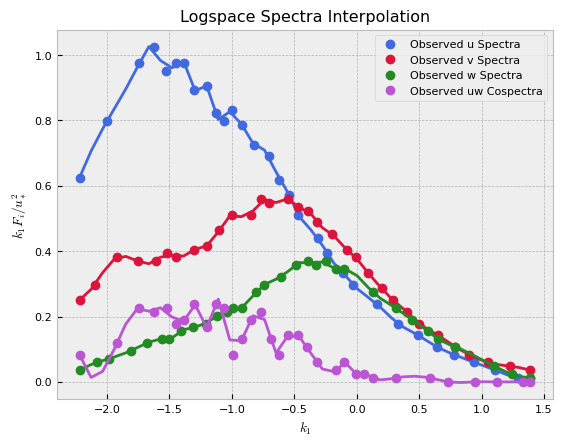

Filtering provided spectra interpolation.


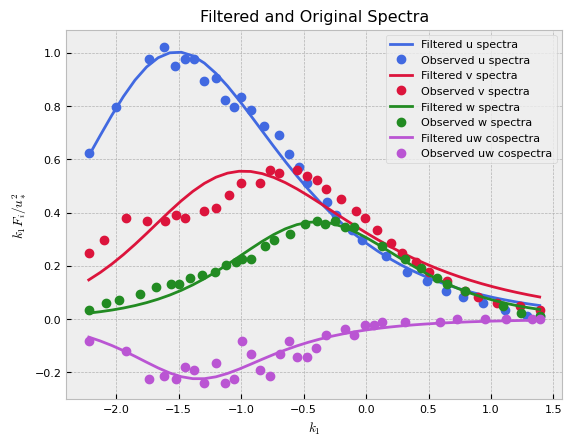

In [3]:
x_coords_u, u_spectra = extract_x_spectra(datapath / "u_spectra.csv")
x_coords_v, v_spectra = extract_x_spectra(datapath / "v_spectra.csv")
x_coords_w, w_spectra = extract_x_spectra(datapath / "w_spectra.csv")
x_coords_uw, uw_cospectra = extract_x_spectra(datapath / "uw_cospectra.csv")
x_full = [x_coords_u, x_coords_v, x_coords_w, x_coords_uw]
spectra_full = [u_spectra, v_spectra, w_spectra, uw_cospectra]
x_interp, interp_u, interp_v, interp_w, interp_uw = interpolate(
    datapath, num_k1_points=40, plot=True
)
domain = torch.tensor(x_interp)

f = domain
k1_data_pts = 2 * torch.pi * f / Uref

interpolated_spectra = np.stack((interp_u, interp_v, interp_w, interp_uw), axis=1)

datagen = OnePointSpectraDataGenerator(
    zref=zref,
    data_points=k1_data_pts,
    data_type=DataType.AUTO,
    k1_data_points=(
        k1_data_pts.cpu().numpy() if torch.cuda.is_available() else k1_data_pts.numpy()
    ),
    spectra_values=interpolated_spectra,
)

datagen.plot(x_interp, spectra_full, x_full)

## ``CalibrationProblem`` construction

We'll use a simple neural network consisting of two layers with $10$ neurons each,
connected by a ReLU activation function. The parameters determining the network
architecture can conveniently be set through the ``NNParameters`` dataclass.

Using the ``ProblemParameters`` dataclass, we indicate the eddy lifetime function
$\tau$ substitution, that we do not intend to learn the exponent $\nu$,
and that we would like to train for 10 epochs, or until the tolerance ``tol`` loss (0.001 by default),
whichever is reached first.

Having set our physical parameters above, we need only pass these to the
``PhysicalParameters`` dataclass just as is done below.

Lastly, using the ``LossParameters`` dataclass, we introduce a second-order
derivative penalty term with weight $\alpha_2 = 1$ and a
network parameter regularization term with weight
$\beta=10^{-5}$ to our MSE loss function.

The $\nu$ parameter is not learned in this example and is instead fixed at $\nu = - 1/3$.



In [4]:
pb = CalibrationProblem(
    nn_params=NNParameters(
        nlayers=2,
        hidden_layer_sizes=[10, 10],
        activations=[nn.ReLU(), nn.ReLU()],
    ),
    prob_params=ProblemParameters(nepochs=5),
    loss_params=LossParameters(alpha_pen2=1.0, beta_reg=1e-5),
    phys_params=PhysicalParameters(
        L=L, Gamma=Gamma, sigma=sigma, Uref=Uref, domain=domain
    ),
    logging_directory="runs/interpolating_and_fitting",
    device=device,
)
Data = datagen.Data

## Calibration
Now, we fit our model. ``CalibrationProblem.calibrate`` takes the tuple ``Data``
which we just constructed and performs a typical training loop.



In [5]:
pb.eval(k1_data_pts)
optimal_parameters = pb.calibrate(data=Data)

pb.print_calibrated_params()

Initial loss: 7.707574696804095


  0%|                                                                          | 0/5 [00:00<?, ?it/s]

 20%|█████████████▏                                                    | 1/5 [00:05<00:22,  5.65s/it]

 40%|██████████████████████████▍                                       | 2/5 [00:09<00:13,  4.40s/it]

 60%|███████████████████████████████████████▌                          | 3/5 [00:12<00:08,  4.01s/it]

 80%|████████████████████████████████████████████████████▊             | 4/5 [00:16<00:03,  3.88s/it]

100%|██████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  3.86s/it]

100%|██████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]

Spectra fitting concluded with final loss: 0.05668436288880432
Optimal calibrated L        :  16.8054 
Optimal calibrated Γ        :   2.9040 
Optimal calibrated αϵ^{2/3} :   0.8251 


## Plotting
``DRDMannTurb`` offers built-in plotting utilities and Tensorboard integration
which make visualizing results and various aspects of training performance
very simple.

The following will plot our fit. As can be seen, the spectra is much smoother than the original
spectra, which we investigated in the previous example.



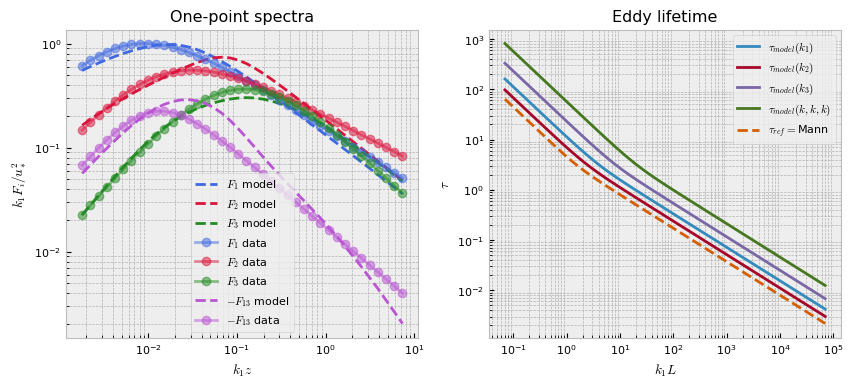

In [6]:
pb.plot()

This plots out the loss function terms as specified, each multiplied by the
respective coefficient hyperparameter. The training logs can be accessed from the logging directory
with Tensorboard utilities, but we also provide a simple internal utility for a single
training log plot.



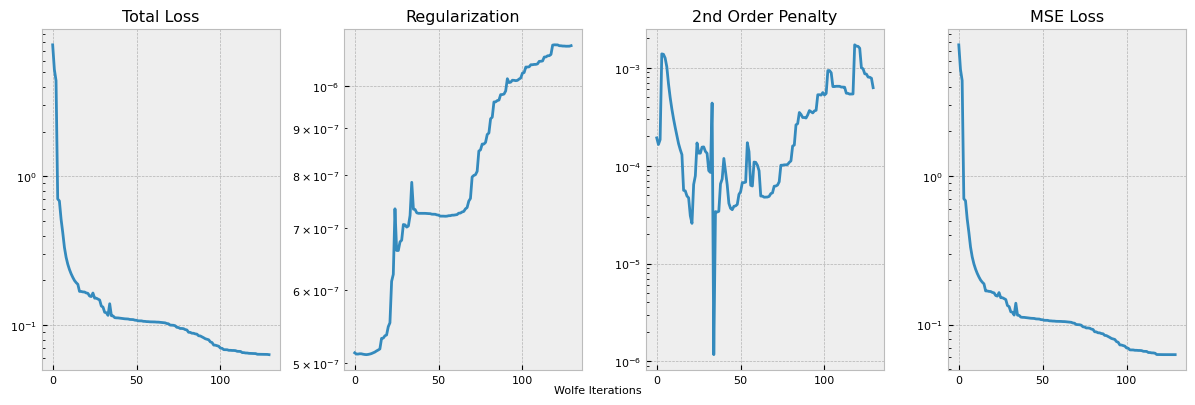

In [7]:
pb.plot_losses(run_number=0)